In [5]:
# # QC tensorflow installation
# import tensorflow as tf
# import keras
# print(tf.__version__)
# print(keras.__version__)

# Command Space
# %

## Import Libraries

In [6]:
# Import required libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import os

## Load CIFAR-10 Dataset

We load the CIFAR-10 dataset, perform some preprocessing like normalization and one hot encoding of labels/targets.

In [7]:
import numpy as np
import os

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10_train_test(data_dir):
    """
    Function to load CIFAR-10 training and test data.

    Args:
    data_dir (str): Path to the directory containing CIFAR-10 data files.

    Returns:
    X_train (ndarray): Training data features
    Y_train (ndarray): Training data labels
    X_test (ndarray): Test data features
    Y_test (ndarray): Test data labels
    """
    X_train = []
    Y_train = []

    for i in range(1, 6):  # Load training data from 5 batches
        # batch_file = os.path.join(data_dir, 'data_batch_' + str(i))
        batch_data = unpickle(batch_file)
        X_train.append(batch_data[b'data'])
        Y_train += batch_data[b'labels']

    X_train = np.concatenate(X_train, axis=0)
    Y_train = np.array(Y_train)

    # Load test data from the test batch
    test_batch_file = os.path.join(data_dir, 'test_batch')
    test_batch_data = unpickle(test_batch_file)

    X_test = test_batch_data[b'data']
    Y_test = np.array(test_batch_data[b'labels'])

    # Reshaping and re-arranging color channels to represent RGB image required as input to CNN
    # Reshape to (50000, 3, 32, 32) and move the color channel axis to the last dimension
    X_train = X_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    X_test = X_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    return X_train, Y_train, X_test, Y_test


Create validation data from train set (20% split):

In [11]:
from sklearn.model_selection import train_test_split

# Directory containing CIFAR-10 data files
data_dir = 'Data\cifar-10-batches-py'

# Load CIFAR-10 training and test data
X_train, Y_train, X_test, Y_test = load_cifar10_train_test(data_dir)

# Split the training data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

FileNotFoundError: [Errno 2] No such file or directory: 'Data\\cifar-10-batches-py\\data_batch_1'

In [ ]:
# Ensuring we parsed the data correctly:
print('Train Set:')
print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)
print('Validation Set:')
print('X_val shape: ', X_val.shape)
print('Y_val shape: ', Y_val.shape)
print('Test Set:')
print('X_test shape: ', X_test.shape)
print('Y_test shape: ', Y_test.shape)

Train Set:
X_train shape:  (40000, 32, 32, 3)
Y_train shape:  (40000,)
Validation Set:
X_val shape:  (10000, 32, 32, 3)
Y_val shape:  (10000,)
Test Set:
X_test shape:  (10000, 32, 32, 3)
Y_test shape:  (10000,)


### Setup ImageDataGenerator

In order to make the most of fewer training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

NOTE: ImageDataGenerator will NOT add new images to your data set in a sense that it will not make your epochs bigger. Instead, in each epoch it will provide slightly altered images (depending on your configuration). It will always generate new images, no matter how many epochs you have.

So in each epoch model will train on different images, but not too different. This should prevent overfitting and in some way simulates online learning.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Construct the training image generator for data augmentation
datagen = ImageDataGenerator(
        rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        # brightness_range=[0.2,1.0] # brightness
)

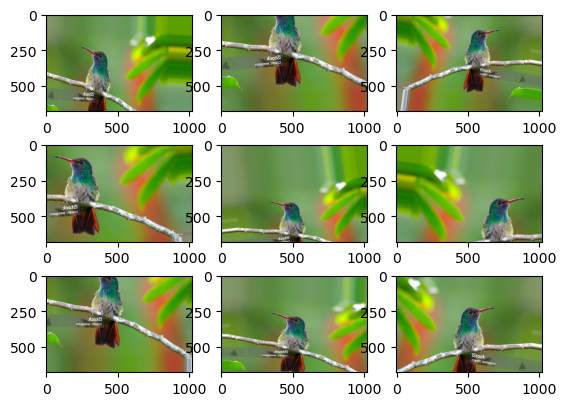

In [ ]:
# Example of image augmentation on sample image:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot


img = load_img('bird.jpeg') # load image
data = img_to_array(img) # convert to numpy array
samples = expand_dims(data, 0) # expand dimension to one sample

# Prepare iterator
it = datagen.flow(samples, batch_size=1)

# Generate samples and plot
for i in range(9):
    pyplot.subplot(330 + 1 + i) # define subplot
    batch = it.next() # generate batch of images
    image = batch[0].astype('uint8') # convert to unsigned integers
    pyplot.imshow(image)

# show the figure
pyplot.show()
# Adapted code for displaying augmentation results: https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

### Pre-processing dataset

In [ ]:
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

# One-hot encode the labels
Y_train = to_categorical(Y_train, 10)
Y_test = to_categorical(Y_test, 10)
Y_val = to_categorical(Y_val, 10)

## Build and Train Model

The following cell has the supporting utility functions to plot accuracy curves, loss curves from training process and final evaluation of the classification model. I have provided inline comments explaining purpose of each function and code used. 

In [ ]:
# Import required libraries
import matplotlib.pyplot as plt

def plot_accuracy(history, title):
    """
    Function to plot accuracy curves for both training and validation sets.

    Args:
    history (History): Keras History object containing training history
    title (str): Title of the plot
    """
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    # savefig(filename) - add filename argument
    plt.show()

def plot_loss(history, title):
    """
    Function to plot loss curves for both training and validation sets.

    Args:
    history (History): Keras History object containing training history
    title (str): Title of the plot
    """
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

def evaluate_model(model, X_test, Y_test):
    """
    Function to evaluate the performance of a trained model on the test dataset.

    Args:
    model (Sequential): Trained Keras model
    X_test (ndarray): Test dataset features
    Y_test (ndarray): One-hot encoded labels for test dataset
    """
    _, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print("Test Accuracy: %.2f%%" % (accuracy * 100))


In [ ]:
from tensorflow.keras.layers import Input, Add, Activation, AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

def resnet_block(inputs, filters, kernel_size, strides, activation='relu'):
    """
    Function to create a single ResNet block.

    Args:
    inputs (tensor): Input tensor
    filters (int): Number of filters in the convolutional layers
    kernel_size (int or tuple): Size of the convolutional kernel
    strides (int or tuple): Strides of the convolutional kernel
    activation (str): Activation function to use

    Returns:
    tensor: Output tensor of the ResNet block
    """
    shortcut = inputs

    # First convolutional layer
    x = Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    # Second convolutional layer
    x = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    # Shortcut connection
    if strides != 1 or inputs.shape[-1] != filters:
        # change (1,1) to variable (the kernel size in the ith skip connection)
        shortcut = Conv2D(filters, (1, 1), strides=strides, padding='same', kernel_initializer='he_normal')(inputs)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation(activation)(x)
    return x

def build_resnet():
    """
    Function to build a ResNet model using multiple Resnet style blocks.

    Returns:
    model (Model): Compiled ResNet model
    """
    inputs = Input(shape=(32, 32, 3))
    num_filters = 64
    # potentially a hyperparameter eg: [2, 3, 2]
    num_blocks_list = [2, 2]  # ResNet Style architecture for CIFAR-10

    x = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Add ResNet blocks
    for i, num_blocks in enumerate(num_blocks_list):
        for j in range(num_blocks):
            strides = 1
            if i > 0 and j == 0:  # Downsample at the beginning of each stage
                strides = 2
            x = resnet_block(x, num_filters, (3, 3), strides)

        num_filters *= 2  # Double the number of filters after each stage

    x = AveragePooling2D(pool_size=(8, 8))(x) # pool size could be hyperparameter
    x = Flatten()(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    # optimizer can be a parameter: vanilla sgd, sgd with fixed learning rate, or adam 
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
# Build ResNet model
resnet_model = build_resnet()
resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 32, 32, 64)           0         ['batch_normalization[0][0

2024-04-10 21:25:11.660374: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-04-10 21:25:11.660390: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-04-10 21:25:11.660393: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-04-10 21:25:11.660416: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-10 21:25:11.660427: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


TO DO:
1. keras callbacks: save checkpoint with best performance on validation data (rishie)
2. Add hyperparameter tuning as arguments (gio)
3. Save graphs under different names (gio)
4. ImageDataGenerator - read about this to add augmentation (rishie)
5. Regularization - Dropouts in random/hyperparameter
6. Loading custom data (rishie)

### Enabling Keras Callbacks

Callback to save the Keras model weights after every epoch that obtains the best validation accuracy thus far.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Filepath for storing model weights
checkpoint_filepath = 'ckpt/model_checkpoint_testing'

# Defining callback
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Augmenting on the fly with datagen.flow()
batch_size=64
epochs=10

# Directly use .flow() to load our dataset in batches for training
resnet_history = resnet_model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size), 
                                  epochs = epochs, # set number of epochs
                                  steps_per_epoch = X_train.shape[0]//batch_size, # number of images composing one epoch
                                  validation_data = (X_val, Y_val), # data for validation
                                  callbacks=[model_checkpoint_callback], # model checkpoint
                                  verbose=1)

Epoch 1/10
625/625 [==============================] - ETA: 0s - loss: 0.4088 - accuracy: 0.8595INFO:tensorflow:Assets written to: ckpt/model_checkpoint/assets


INFO:tensorflow:Assets written to: ckpt/model_checkpoint/assets


625/625 [==============================] - 34s 55ms/step - loss: 0.4088 - accuracy: 0.8595 - val_loss: 0.7378 - val_accuracy: 0.7865
Epoch 2/10
624/625 [============================>.] - ETA: 0s - loss: 0.3863 - accuracy: 0.8665INFO:tensorflow:Assets written to: ckpt/model_checkpoint/assets


INFO:tensorflow:Assets written to: ckpt/model_checkpoint/assets


625/625 [==============================] - 34s 55ms/step - loss: 0.3867 - accuracy: 0.8663 - val_loss: 0.4362 - val_accuracy: 0.8578
Epoch 3/10
625/625 [==============================] - 34s 54ms/step - loss: 0.3829 - accuracy: 0.8682 - val_loss: 1.3031 - val_accuracy: 0.7005
Epoch 4/10
625/625 [==============================] - 33s 52ms/step - loss: 0.3693 - accuracy: 0.8716 - val_loss: 1.0950 - val_accuracy: 0.7389
Epoch 5/10
625/625 [==============================] - 33s 52ms/step - loss: 0.3612 - accuracy: 0.8774 - val_loss: 0.7003 - val_accuracy: 0.7941
Epoch 6/10
625/625 [==============================] - 33s 53ms/step - loss: 0.3439 - accuracy: 0.8828 - val_loss: 0.6476 - val_accuracy: 0.8177
Epoch 7/10
625/625 [==============================] - 33s 53ms/step - loss: 0.3396 - accuracy: 0.8826 - val_loss: 0.7049 - val_accuracy: 0.7983
Epoch 8/10
625/625 [==============================] - 32s 52ms/step - loss: 0.3281 - accuracy: 0.8870 - val_loss: 0.5427 - val_accuracy: 0.8448
Epo

In [ ]:
# resnet_history = resnet_model.fit(X_train, Y_train, batch_size=64, epochs=10, verbose=1, validation_data=(X_val, Y_val))


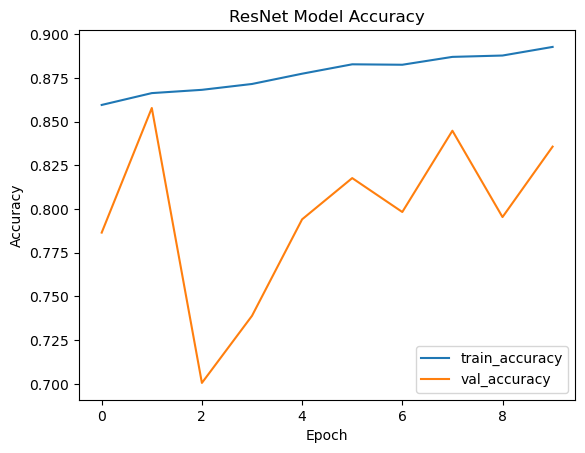

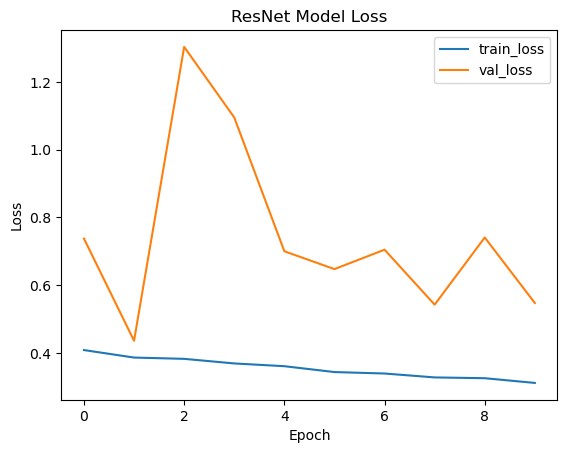

ResNet Model:
Test Accuracy: 82.32%


In [ ]:
# Plot accuracy and loss
plot_accuracy(resnet_history, 'ResNet Model Accuracy')
plot_loss(resnet_history, 'ResNet Model Loss')

# Evaluate the model
print('ResNet Model:')
evaluate_model(resnet_model, X_test, Y_test)

In [ ]:
# The model weights (that are considered the best) can be loaded as -
test_model = tf.keras.models.load_model(checkpoint_filepath)